# 1. Introduction

## Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


## Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

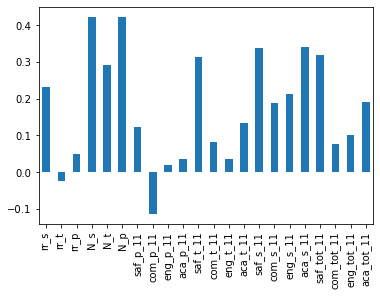

In [11]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline


combined.corr()["sat_score"][survey_fields].plot.bar()

plt.show()

Above we can see high correlations between N_s and SAT Scores and N_p and SAT scores. As we saw earlier, SAT Scores correlate positively with enrollment, so it makes sense that it'd also correlate highly with the number of student/parent responses.

What's surprising is the fact that the student response rate correlates much more with SAT Scores than teacher response rate and parent response rate. This seems to suggest that students caring enough to fill out the surveys indicates that they are also more likely to d well on the SATs. However, the parent and teacher response rate does not correlate with SAT scores, perhaps since they'd feel obligated to respond regardless.

We also see that safety and academic expectation scores correlate positively with SAT Scores.

![](https://s3.amazonaws.com/dq-content/xj5ud4r.png)

# 2. Exploring Safety and SAT Scores

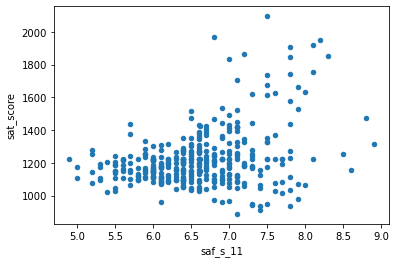

In [12]:
combined.plot.scatter(x="saf_s_11",y="sat_score")

plt.show()

There is a decently positive correlation between student saftey and SAT Scores, but it is not too strong.

However, we can see that no school with a student safety rating below 6.5 had an average SAT score over about 1500. On the other hand, there are many schools that averaged about a 1500 with a satefy score above 6.5

In [14]:
boroughs=combined.groupby("boro").agg(numpy.mean)["saf_s_11"]
print(boroughs)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


We can see that Manhattan and Queens have the highest safety scores while Brooklyn is at the bottom with the Bronx and Staten Island in between.

# 3. Exploring Race and SAT Scores

<AxesSubplot:>

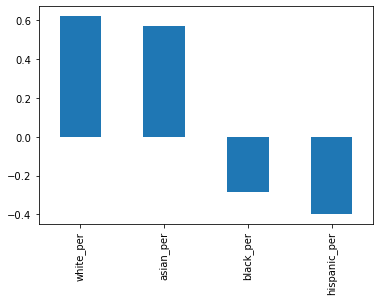

In [16]:
races=["white_per","asian_per","black_per","hispanic_per"]

combined.corr()["sat_score"][races].plot.bar()

We can see above that percent of students being Asian or White correlates positively to SAT Scores while percent of students being Black or Hispanic correlates negatively to SAT Scores.

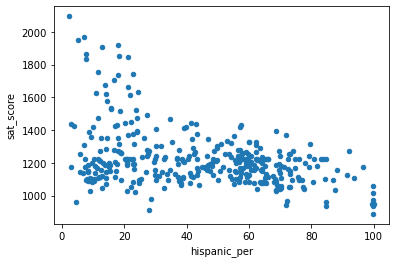

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [25]:
combined.plot.scatter(x="hispanic_per",y="sat_score")

plt.show()

print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

We can see above that there are some very low SAT scoring schools with nearly all hispanic students. These seem to be schools which are geared more towards international students which could mean that the students there are still learning English which could explain the low SAT scores.

In [36]:
print(combined[(combined["hispanic_per"]<10) & (combined["sat_score"]>1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


It looks like these are technical high schools that have entrance exams and more funding which explains the high SAT scores. However this does not explain the low Hispanic students percentages.

# 4. Exploring Gender and SAT Scores

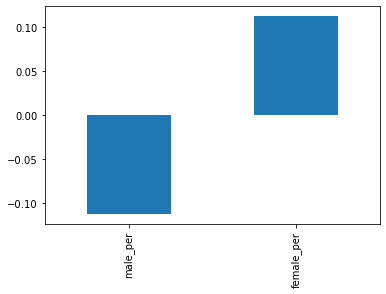

In [41]:
combined.corr()["sat_score"][["male_per","female_per"]].plot.bar()

plt.show()

We can see that SAT scores are positively correlated with female percentage and thus negatively correlated with male percentage. However, neither correlation is that strong.

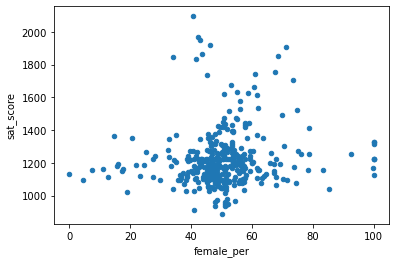

In [42]:
combined.plot.scatter(x="female_per",y="sat_score")
plt.show()

We can see again that the correlation between female percentage and SAT scores is pretty low.

In [43]:
combined[(combined["female_per"]>60) & (combined["sat_score"]>1700)]

DBN                                        SCHOOL NAME  \
5    01M696                     BARD HIGH SCHOOL EARLY COLLEGE   
26   02M416                      ELEANOR ROOSEVELT HIGH SCHOOL   
60   03M479                                 BEACON HIGH SCHOOL   
61   03M485  FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...   
302  25Q525                        TOWNSEND HARRIS HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
5                      130                            624.0   
26                     127                            572.0   
60                     261                            577.0   
61                     531                            566.0   
302                    278                            621.0   

     SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
5                  604.0                   628.0     1856.0   
26                 594.0                   592.0     1758.0   
60                 575.0                   592.0     1744.0   
61                 564.0                   577.0     1707.0   
302                651.0                   638.0     1910.0   

                        SchoolName  AP Test Takers   Total Exams Taken  ...  \
5                                0       129.028846         197.038462  ...   
26   Eleanor Roosevelt High School       155.000000         235.000000  ...   
60                   BEACON SCHOOL       166.000000         197.000000  ...   
61         FIORELLO H.LAGUARDIA HS       691.000000        1236.000000  ...   
302             TOWNSEND HARRIS HS       613.000000         796.000000  ...   

     priority05 priority06 priority07 priority08  priority09 priority10  \
5             0          0          0        0.0         0.0        0.0   
26            0          0          0        0.0         0.0        0.0   
60            0          0          0        0.0         0.0        0.0   
61            0          0          0        0.0         0.0        0.0   
302           0          0          0        0.0         0.0        0.0   

                                            Location 1        lat        lon  \
5    525 East Houston Street\nNew York, NY 10002\n(...  40.718962 -73.976066   
26   411 East 76 Street\nNew York, NY 10021\n(40.77...  40.770116 -73.953379   
60   227-243 West 61St Street\nNew York, NY 10023\n...  40.772158 -73.987797   
61   100 Amsterdam Avenue\nNew York, NY 10023\n(40....  40.773671 -73.985269   
302  149-11 Melbourne Avenue\nFlushing, NY 11367\n(...  40.734408 -73.821417   

    school_dist  
5            01  
26           02  
60           03  
61           03  
302          25  

[5 rows x 160 columns]

We can see here that schools that have high female percentage and high SAT scores tend to be selective liberal arts high schools.

# 5. Exploring AP Scores vs. SAT Scores

0.05717081390766967


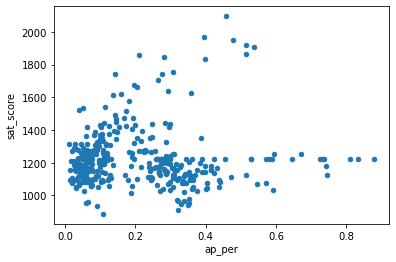

In [52]:
combined["ap_per"]=combined["AP Test Takers "]/combined["total_enrollment"]

combined.plot.scatter(x="ap_per",y="sat_score")

print(combined.corr()["sat_score"]["ap_per"])

plt.show()

One might expect that having a higher percentage of students taking AP Exams would correlate highly with SAT scores, however that isn't the case. The correlation between the two is negligible. 

Schools that had more than about 55% of the school take AP exams didn't score much more than 1200 on the SATs.

# 6. Next Steps

We've done quite a bit of investigation into relationships between demographics and SAT scores in this guided project. There's still quite a bit of analysis left to do, however. Here are some potential next steps:

Determe whether there's a correlation between class size and SAT scores
Figure out which neighborhoods have the best schools
If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
Investigate the differences between parent, teacher, and student responses to surveys.
Assign scores to schools based on sat_score and other attributes.
We recommend you create a GitHub repository and place this project there. It will help other people see your work, including employers. As you start to put multiple projects on GitHub, you'll have the beginnings of a strong portfolio.

You're welcome to keep working on the project here, but we recommend you download it to your computer using the download icon above and work on it there.

Curious to see what other students have done on this project? Head over to our Community to check them out. While you are there, please remember to give us your feedback!

We welcome you to share your own project and show off your hard work. Head over to our Community to share your finished Guided Project!